# Setup

In [1]:
!pip install xgboost > /dev/null
!pip install kaggle > /dev/null

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import xgboost as xgb

from xgboost.callback import EvaluationMonitor

In [3]:
pd_clean_train = pd.read_csv("./data/clean/train.csv", index_col='PassengerId')
pd_clean_test = pd.read_csv("./data/clean/test.csv", index_col='PassengerId')
pd_sample_submission = pd.read_csv("../input/sample_submission.csv")

In [4]:
pd_clean_train.info()
pd_clean_train.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Survived     100000 non-null  int64  
 1   Pclass       100000 non-null  int64  
 2   Name         100000 non-null  object 
 3   Sex          100000 non-null  object 
 4   Age          96708 non-null   float64
 5   SibSp        100000 non-null  int64  
 6   Parch        100000 non-null  int64  
 7   Ticket       95377 non-null   object 
 8   Fare         99866 non-null   float64
 9   Cabin        32134 non-null   object 
 10  Embarked     99750 non-null   object 
 11  family       100000 non-null  int64  
 12  ticket_type  24655 non-null   object 
 13  ticket_num   94704 non-null   float64
 14  cabin_id     100000 non-null  object 
 15  surname      100000 non-null  object 
dtypes: float64(3), int64(5), object(8)
memory usage: 13.0+ MB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family,ticket_type,ticket_num,cabin_id,surname
PassengerId,,,,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,2,NaN,209245.0,C,Oconnor


# Create Modeling Datasets

In [13]:
def format_dataset(pd_df):
    dataset_cols = [
        'Sex',
        'Embarked',
        'Pclass',
        'Age',
        'SibSp',
        'Parch',
        'Fare',
        'family',
        'ticket_type',
        'cabin_id',
        'Survived']
    
    return pd_df.loc[:, [col for col in dataset_cols if col in pd_df.columns]]


def one_hot_encode(pd_df):
    pd_df = pd.get_dummies(pd_df, columns=['Sex', 'Embarked', 'ticket_type', 'cabin_id'], dummy_na=True)
    pd_df = pd_df.drop('Sex_nan', axis=1)  # no null values exist in training or test set
    
    return pd_df

In [14]:
pd_model_train = (pd_clean_train
    .pipe(format_dataset)
    .pipe(one_hot_encode))
pd_model_test = (pd_clean_test
    .pipe(format_dataset)
    .pipe(one_hot_encode))

In [15]:
pd_model_train.head(1)

,Pclass,Age,SibSp,Parch,Fare,family,Survived,Sex_female,Sex_male,Embarked_C,...,cabin_id_A,cabin_id_B,cabin_id_C,cabin_id_D,cabin_id_E,cabin_id_F,cabin_id_G,cabin_id_T,cabin_id_n,cabin_id_nan
PassengerId,,,,,,,,,,,,,,,,,,,,,
0,1,NaN,2,0,27.14,2,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


# Train-Validation Split

In [16]:
pd_train = pd_model_train.sample(frac=0.8, random_state=3)
pd_valid = pd_model_train.drop(pd_train.index)

# Train Model

In [17]:
# Train setup
X_train = pd_train.drop('Survived', axis=1)
X_valid = pd_valid.drop('Survived', axis=1)
y_train = pd_train.Survived
y_valid = pd_valid.Survived

clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_lambda=1,
    random_state=3,
    tree_method='hist',
    use_label_encoder=False)

In [18]:
%%time
clf.fit(
    X=X_train, 
    y=y_train, 
    verbose=False,
    eval_metric=['logloss', 'error'],
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    callbacks=[EvaluationMonitor(period=25)])

[0]	validation_0-logloss:0.67503	validation_0-error:0.22094	validation_1-logloss:0.67529	validation_1-error:0.22315
[25]	validation_0-logloss:0.50316	validation_0-error:0.21896	validation_1-logloss:0.50770	validation_1-error:0.22240
[50]	validation_0-logloss:0.47637	validation_0-error:0.21761	validation_1-logloss:0.48351	validation_1-error:0.22140
[75]	validation_0-logloss:0.46981	validation_0-error:0.21677	validation_1-logloss:0.47862	validation_1-error:0.22135
[100]	validation_0-logloss:0.46681	validation_0-error:0.21518	validation_1-logloss:0.47687	validation_1-error:0.22130
[125]	validation_0-logloss:0.46495	validation_0-error:0.21456	validation_1-logloss:0.47602	validation_1-error:0.22145
[150]	validation_0-logloss:0.46346	validation_0-error:0.21338	validation_1-logloss:0.47553	validation_1-error:0.22155
[175]	validation_0-logloss:0.46236	validation_0-error:0.21299	validation_1-logloss:0.47524	validation_1-error:0.22155
[200]	validation_0-logloss:0.46134	validation_0-error:0.21214

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=3, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Evaluate Model

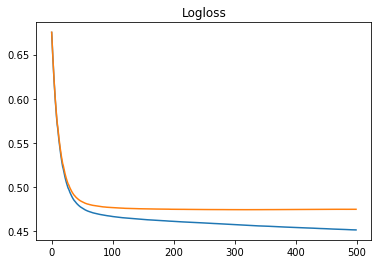

Minimum: 0.474526 (n_trees=311)


In [19]:
train_logloss = clf.evals_result()['validation_0']['logloss']
valid_logloss = clf.evals_result()['validation_1']['logloss']
plt.plot(train_logloss)
plt.plot(valid_logloss)
plt.title("Logloss")
plt.show()

srs_valid = pd.Series(valid_logloss)
print("Minimum: {} (n_trees={})".format(
    srs_valid[srs_valid.idxmin()], srs_valid.idxmin() + 1))

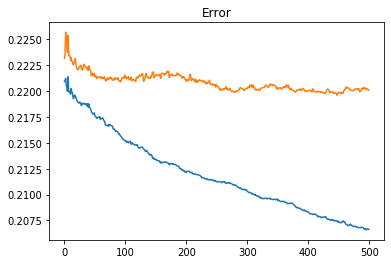

Minimum: 0.2196 (n_trees=448)


In [20]:
train_error = clf.evals_result()['validation_0']['error']
valid_error = clf.evals_result()['validation_1']['error']
plt.plot(train_error)
plt.plot(valid_error)
plt.title("Error")
plt.show()

srs_valid = pd.Series(valid_error)
print("Minimum: {} (n_trees={})".format(
    srs_valid[srs_valid.idxmin()], srs_valid.idxmin() + 1))

# Create Submission

In [21]:
# Update parameters
best_n_estimators = 189
clf = clf.set_params(**{'n_estimators': best_n_estimators})

In [22]:
%%time
X = pd.concat([X_train, X_valid])
y = y_train.append(y_valid)

clf.fit(
    X=X, 
    y=y, 
    verbose=False,
    eval_metric=['logloss', 'error'],
    eval_set=[(X, y)],
    callbacks=[EvaluationMonitor(period=25)])

[0]	validation_0-logloss:0.67511	validation_0-error:0.22117
[25]	validation_0-logloss:0.50440	validation_0-error:0.21989
[50]	validation_0-logloss:0.47782	validation_0-error:0.21878
[75]	validation_0-logloss:0.47138	validation_0-error:0.21730
[100]	validation_0-logloss:0.46858	validation_0-error:0.21553
[125]	validation_0-logloss:0.46670	validation_0-error:0.21477
[150]	validation_0-logloss:0.46527	validation_0-error:0.21428
[175]	validation_0-logloss:0.46419	validation_0-error:0.21390
[188]	validation_0-logloss:0.46382	validation_0-error:0.21372
CPU times: user 14.1 s, sys: 359 ms, total: 14.4 s
Wall time: 1.85 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=189, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=3, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [24]:
# Create sumbission dataset
predictions = clf.predict(pd_model_test)
pd_submission = pd_sample_submission.drop('Survived', axis=1)
pd_submission = pd_submission.assign(Survived=predictions)
pd_submission.to_csv('./submissions/2.0-modelling-xgboost.csv', index=False)

In [28]:
# Submit
!kaggle competitions submit -c tabular-playground-series-apr-2021 -f ./submissions/2.0-modelling-xgboost.csv -m "2.0-modellng-xgboost"

100%|█████████████████████████████████████████| 879k/879k [00:03<00:00, 298kB/s]
Successfully submitted to Tabular Playground Series - Apr 2021